## Convolutions

In [1]:
# Reproduce results
set.seed(1234567)

In [2]:
# Library
library(png)

Before we start talking about convolutional neural-networks, let's remind ourself what a convolution actually does

### Get some data

In [3]:
# Create a function to download an image form url and return a tensor
pngFromUrl <- function(url)
{
  z <- tempfile()
  download.file(url, z, mode="wb")
  pic <- readPNG(z)
  file.remove(z)  
  pic
}

img <- pngFromUrl("https://iliadl.blob.core.windows.net/nnet/hippo.png")
dim(img)  # 250 by 250 x 4(R,G,B,transparency), because it's a PNG not a JPEG

[1] 250 250   4

[1] 250 250


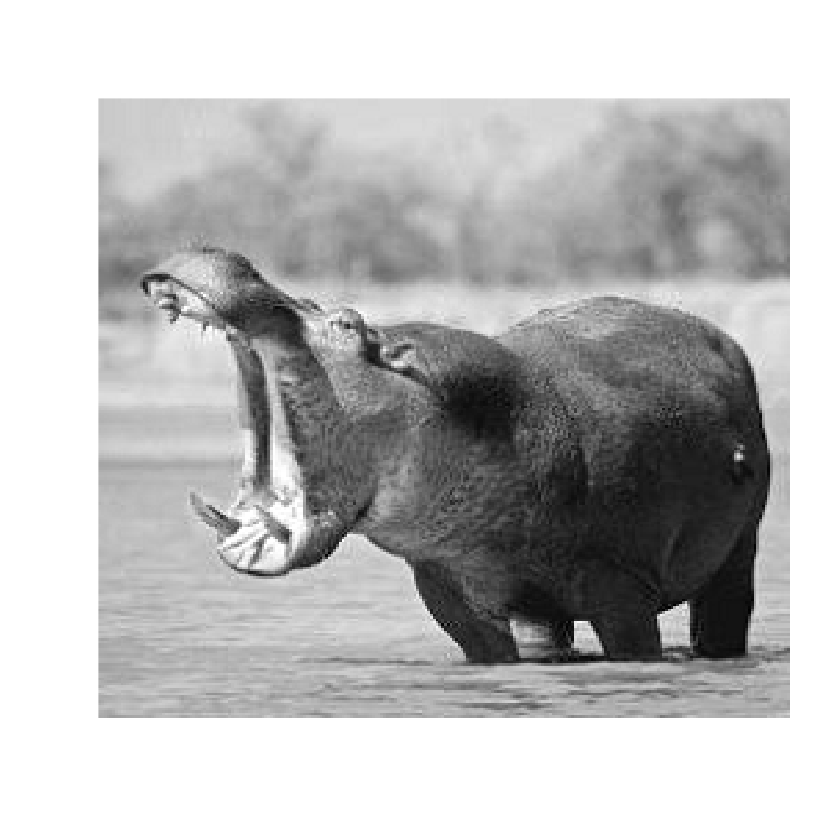

In [4]:
# Let's take the red-colour channel and pretend we have a grey image
# Blue and green would also work ...
r_img <- t(apply(matrix(img[,,1], nrow=250, ncol=250, byrow=FALSE), 2, rev))
print(dim(r_img))  # 250 by 250

# We see a hippo
image(r_img, axes = FALSE, col = grey(seq(0, 1, length = 256)))

### Convolutions from Scratch

          [,1]      [,2]      [,3]
[1,] 0.6627451 0.6784314 0.6901961
[2,] 0.6666667 0.6745098 0.6862745
[3,] 0.6588235 0.6666667 0.6705882


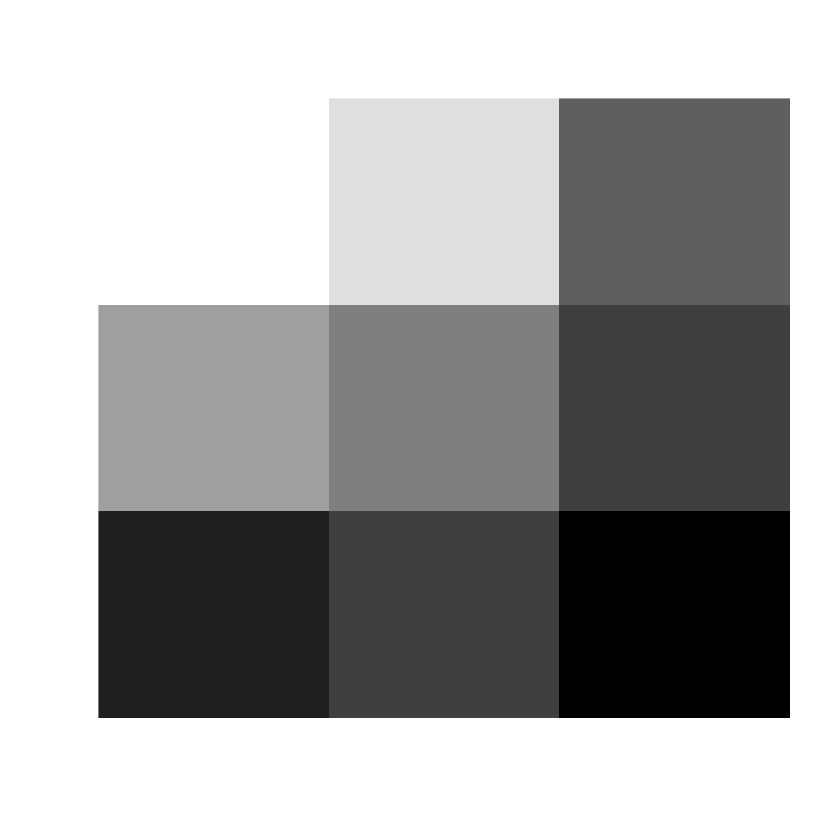

In [5]:
# Lets take a tiny bit from the top left-corner
# 3 by 3 pixels
r_img_3_3 <- r_img[1:3,1:3]
print(r_img_3_3)
image(r_img_3_3, axes = FALSE, col = grey(seq(0, 1, length = 256)))

In [6]:
# Consider the following matrix
# Let's call it a "filter"
# The dimensions of the filter we can call "kernel size"
conv_emboss <- matrix(c(2,0,0,0,-1,0,0,0,-1), nrow = 3)
print(conv_emboss)

# What would happen if we multiplied our tiny chunk with the above matrix?
print(r_img_3_3 * conv_emboss)
# If we take the sum we get a number
print(sum(r_img_3_3 * conv_emboss))

     [,1] [,2] [,3]
[1,]    2    0    0
[2,]    0   -1    0
[3,]    0    0   -1
        [,1]       [,2]       [,3]
[1,] 1.32549  0.0000000  0.0000000
[2,] 0.00000 -0.6745098  0.0000000
[3,] 0.00000  0.0000000 -0.6705882
[1] -0.01960784


This number seems a bit meaningless, so let's perform the same operation, and then repeat for the next column, and repeat. Once we have reached the end, we move onto the next row, and repeat ...

We capture our results in another matrix and then display it as an image.

*Note: If we have a 250 by 250 image and we apply these 3 by 3 filters moving along 1 row/column at a time, we will end up with a matrix that is 250-3+1 by 250-3+1. If this is not trivial try an example on a 5 by 5 matrix. For now we ignore padding*

In [7]:
convolution <- function(input_img, filter, show=TRUE, out=FALSE)
{
  kernel_size <- dim(filter)
  conv_out <- matrix(0,nrow=(nrow(input_img)-kernel_size[[1]]),
                     ncol=(ncol(input_img)-kernel_size[[2]]))
  for (r in 1:(nrow(input_img)-kernel_size[[1]])){
    for (c in 1:(ncol(input_img)-kernel_size[[2]])){
      tiny_chunk <- input_img[r:(r+kernel_size[[1]]-1), c:(c+kernel_size[[2]]-1)]
      conv_out[r, c] <- sum(tiny_chunk*filter)
    }
  }
  if (show){image(conv_out, axes = FALSE, col = grey(seq(0, 1, length = 256)))}
  if (out){conv_out}
}

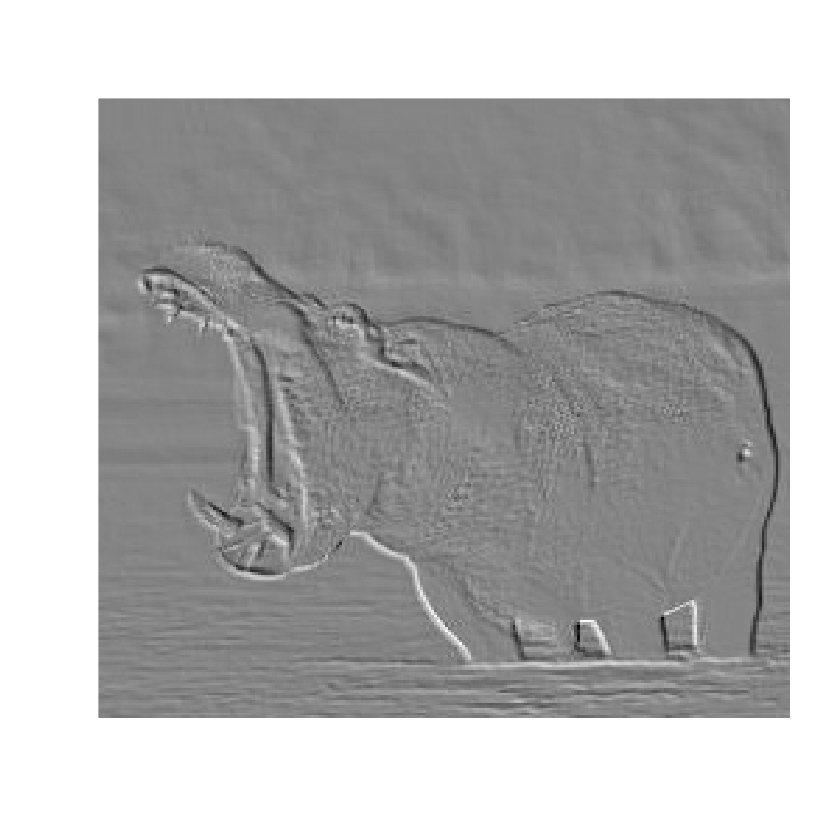

In [8]:
# Now we apply the previous filters across the whole image (3 by 3) at a time
convolution(input_img = r_img, filter = conv_emboss)

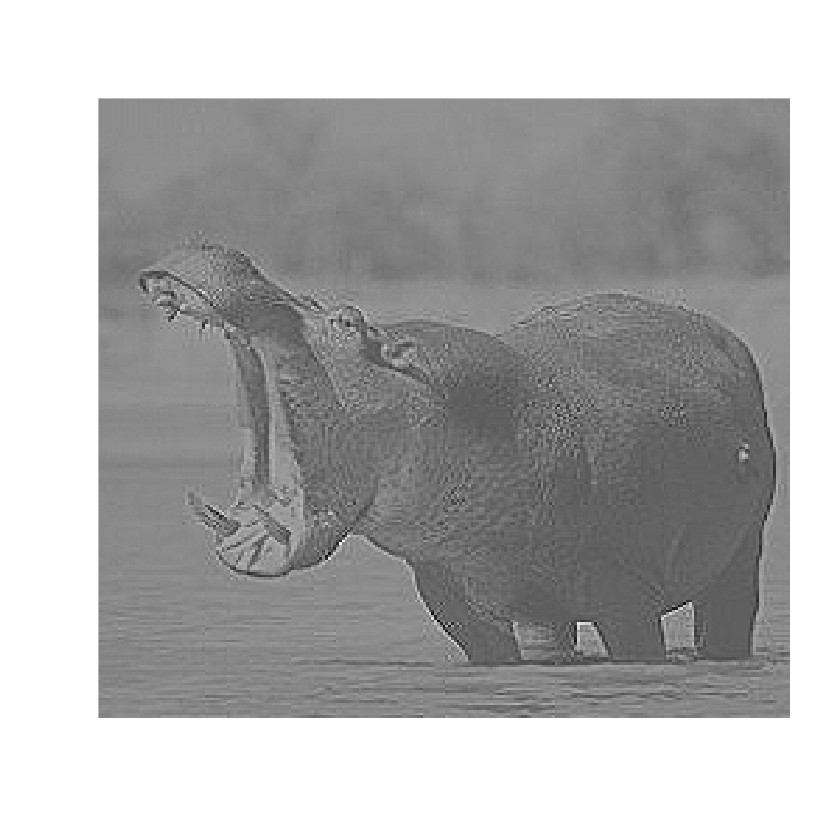

In [9]:
# Let's try some different filters
conv_sharpen <- matrix(c(0,-1,0,-1,5,-1,0,-1,0), nrow = 3)
convolution(input_img = r_img, filter = conv_sharpen)

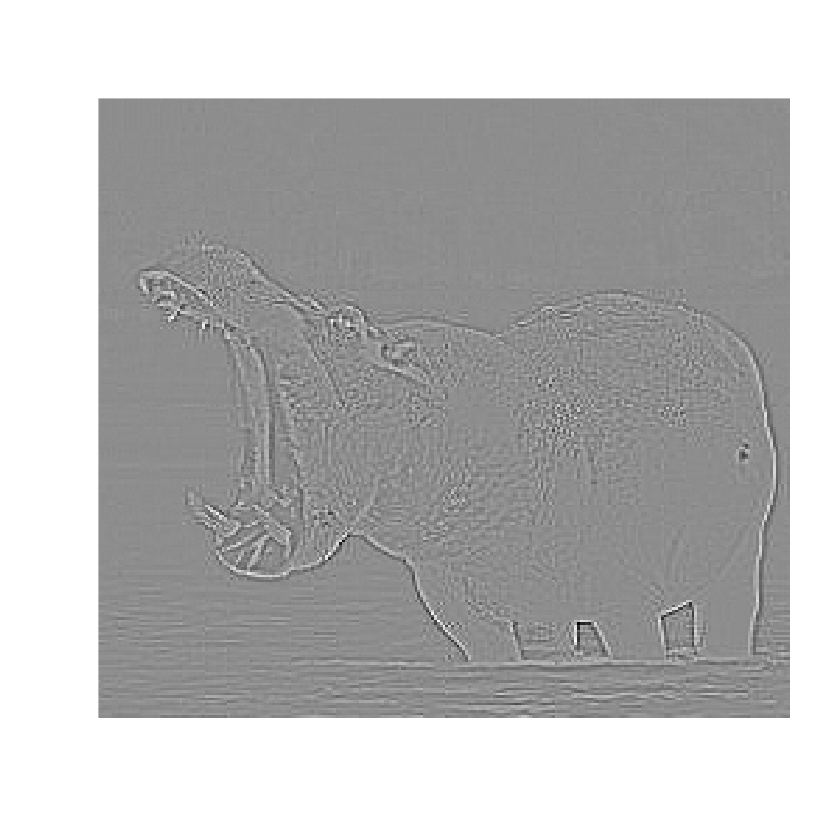

In [10]:
conv_laplace <- matrix(c(.5,1,.5,1,-6,1,.5,1,.5), nrow = 3)
convolution(input_img = r_img, filter = conv_laplace)

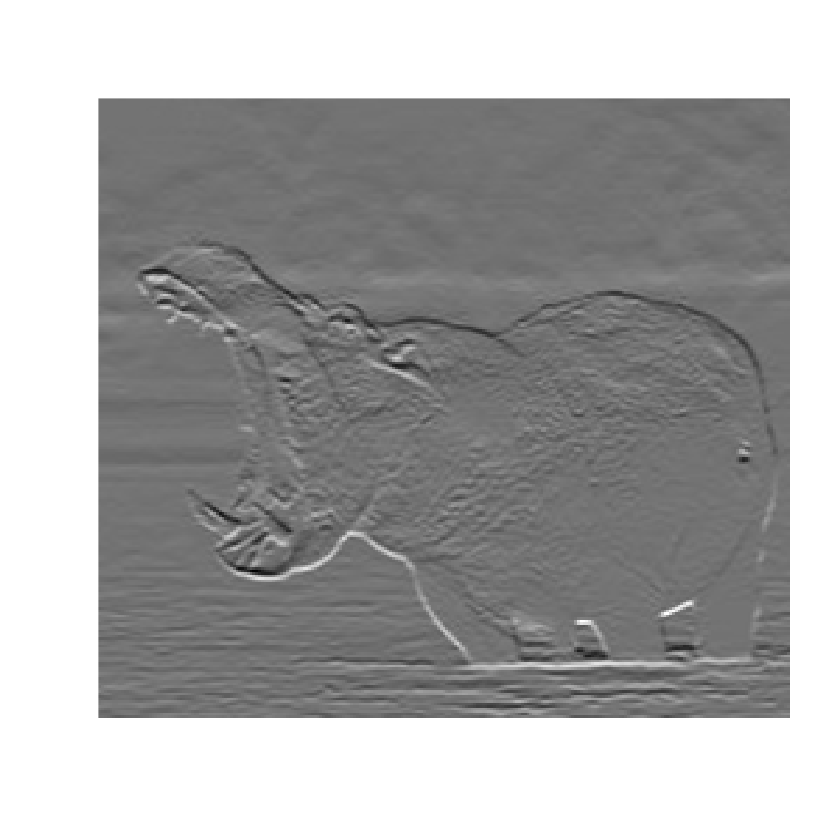

In [11]:
conv_sobel <- matrix(c(1,2,1,0,0,0,-1,-2,-1), nrow=3)
convolution(input_img = r_img, filter = conv_sobel)

So what happens during the training phase of the convolutional layers is that we start with a random-filter like the below and feed-forward the predictions. The filter then gets incrementally updated until it extracts something useful (for the classification) from the image (such as edges, gradients, etc).

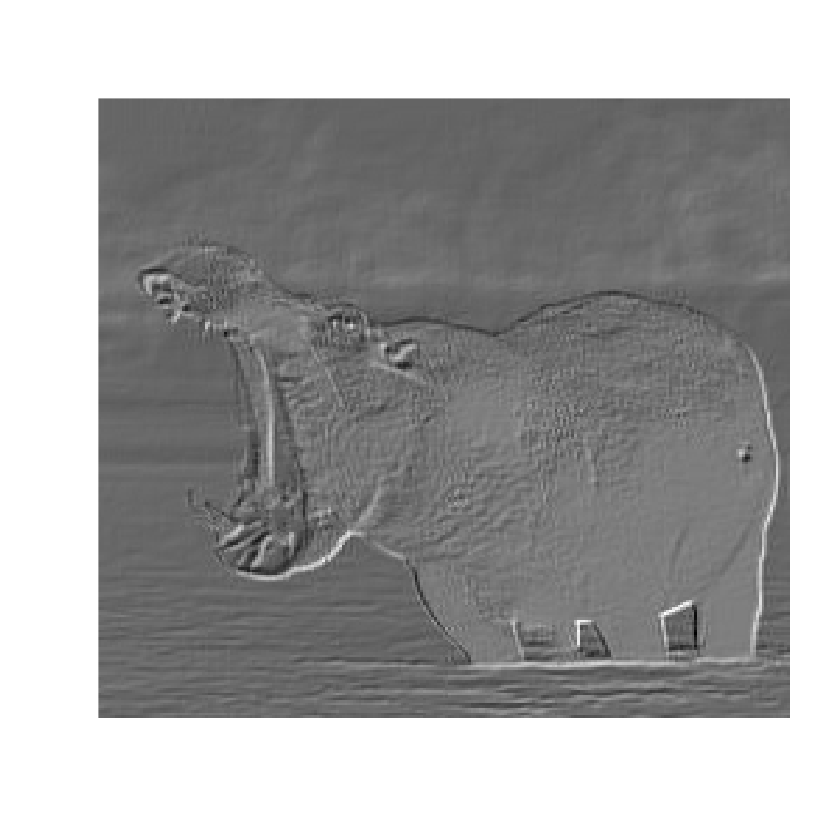

In [12]:
conv_rand <- matrix(rnorm(9), nrow=3)
convolution(input_img = r_img, filter = conv_rand)

In [13]:
# The kinds of operations that occur in convolutional blocks are similar to the below
conv_img <- r_img
print(dim(conv_img))
for (j in 1:10){
    # Apply convolution
    conv_img <- convolution(conv_img, filter=conv_emboss, show=FALSE, out=TRUE)
    # Relu activation z=max(0,z)
    conv_img <- pmax(conv_img, 0)
}
print(dim(conv_img))

[1] 250 250
[1] 220 220


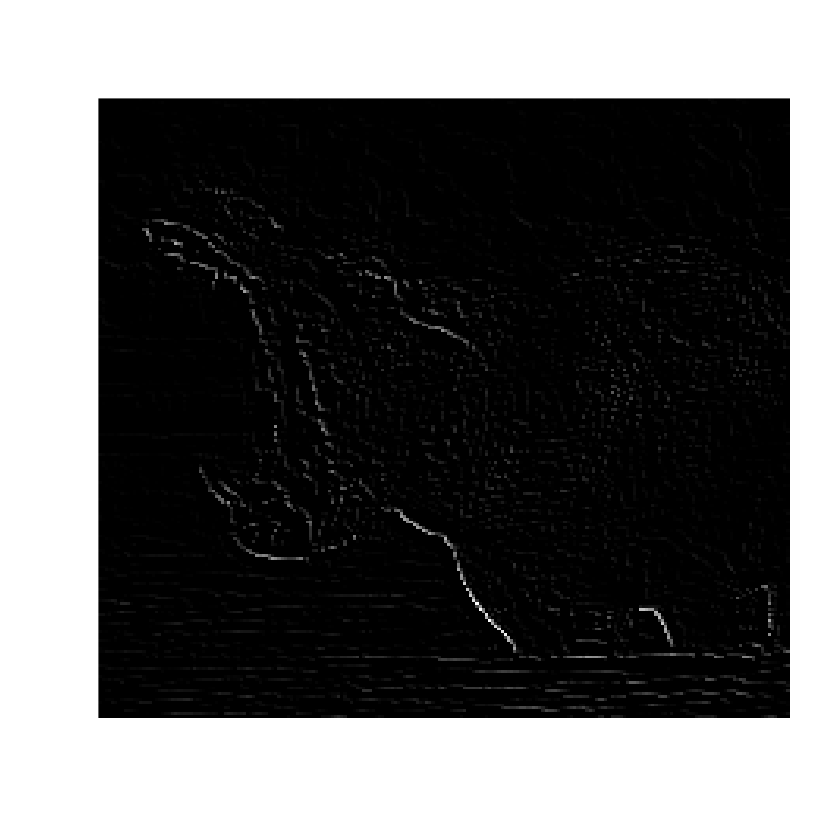

In [14]:
image(conv_img, axes = FALSE, col = grey(seq(0, 1, length = 256)))